# Tweepic: A Novel Approach to Tweet Clustering

Tweepic is a cutting-edge project aimed at the **clustering of live tweets**. Our goal is to collect tweets and discern which ones are discussing the **same topic**,
thereby enabling us to group them accordingly. The name '**Tweepic**' is a portmanteau of 'tweet' and 'topic', reflecting our project's core objective.

Unlike traditional methods that group tweets based solely on hashtags, Tweepic proposes a **novel approach** that also considers the **proximity of sentences** and the similarity of **words** through their embeddings. Our process begins by determining a proximity measure for sentences, words, and hashtags. Using this measure, we construct a **graph** where each vertex represents a tweet, and the edges represent the **k-th nearest tweets**, weighted by their distance. 
Subsequently, a **classifier** is employed to decide which edges should be cut due to significant differences between the connected tweets. This results in the final graph, where each **connected component** represents a cluster of tweets discussing the same topic.

### Team Members

- **Andrea Sanchietti**  - sanchietti.1883210@studenti.uniroma1.it
- **Francesco Palandra** - palandra.1849712@studenti.uniroma1.it

### Important

***The runned notebook was executed with 1 tenth of the dataset. However it can be runned with the whole dataset by changing the sample fraction (or removing it at all) in cell `Train vs Test setup`.***

#### Import Dependencies

In [ ]:
% pip install -r requirements.txt

In [1]:
import sparknlp
from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark import SparkConf
import pyspark
import numpy as np
from scipy.spatial import distance
from pyspark.ml.feature import VectorAssembler, HashingTF
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pyspark.sql.functions import lit 
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from sklearn.decomposition import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import BucketedRandomProjectionLSH
from src.model import pipeline
from pyspark.storagelevel import StorageLevel
from src.utils import *
from src.model import pipeline_v2 
from src.model import graph_pipeline
from src.model import edge_classifier
from igraph import *
from src.utils import *
import config
import graphistry

#### Start the Session

In [2]:
# start the spark session
spark = sparknlp.start(gpu=True, memory=config.spark_memory, params={"spark.jars.packages": "graphframes:graphframes:0.8.1-spark3.0-s_2.12",
                                                                    "spakr.driver.memory": config.spark_memory,
                                                                    # "spark.executor.memory": config.executor_memory,
                                                                    "spark.driver.maxResultSize": config.max_result_memory,
                                                                    "spark.memory.fraction": config.in_memory_fraction,
                                                                    "spark.sql.autoBroadcastJoinThreshold": "-1",
                                                                    "spark.sql.adaptive.enabled": "true",
                                                                    "spark.sql.adaptive.skewJoin.enabled": "true",
                                                                    "spark.sql.shuffle.partitions": "200",})

from graphframes import GraphFrame

23/06/14 00:23:27 WARN Utils: Your hostname, andrea-Pc resolves to a loopback address: 127.0.1.1; using 192.168.1.38 instead (on interface enp7s0)
23/06/14 00:23:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/andrea/miniconda3/envs/tweepic/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/andrea/.ivy2/cache
The jars for the packages stored in: /home/andrea/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp-gpu_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d2fe6f32-2227-4f8c-ad85-a57c5399978f;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp-gpu_2.12;4.4.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#gu

In [3]:
# utils
color_labels = ["red", "blue", "green", "yellow", "orange", "purple", "pink", "brown", "black", "white", "gray", "cyan", "magenta", "lime", "olive", "maroon", "navy", "teal", "silver", "gold", "indigo", "violet", "beige", "turquoise", "salmon", "plum", "khaki", "orchid", "tan", "lavender", "coral"]*2
classes = config.classes
classes.sort()
label_to_color = {label: color_labels[i] for i, label in enumerate(classes)}

#### Offline Model Setup

In [4]:
# create the four pipelines
nlp_pipeline: Pipeline = pipeline_v2.create_embeddings_pipeline(n_buckets=config.n_buckets)
sentence_proximity_pipeline: Pipeline = graph_pipeline.create_sentence_proximity_pipeline(n_neighbors=config.n_neighbors)
word_and_hashtag_proximity_pipeline: Pipeline = graph_pipeline.create_online_word_and_hashtag_proximity_pipeline(n_words=config.n_words, n_hashtags=config.n_hashtags)
edge_classifier_pipeline: Pipeline = edge_classifier.create_edge_classifier_pipeline()

ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7,1 MB
[ | ]ld_wiki_tatoeba_cnn_21 download started this may take some time.
Approximate size to download 7,1 MB
[ / ]Download done! Loading the resource.


2023-06-14 00:23:45.884576: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 00:23:45.916545: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 00:23:45.959730: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 00:23:45.959817: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from Sys

[OK!]
twitter_xlm_roberta_base download started this may take some time.
Approximate size to download 993,4 MB
[ | ]twitter_xlm_roberta_base download started this may take some time.
Approximate size to download 993,4 MB
Download done! Loading the resource.
[ \ ]

2023-06-14 00:23:56.299622: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 00:23:56.299740: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 00:23:56.299783: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 00:23:56.299860: I external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-14 00:23:56.2999

[OK!]


### Fit the Pipelines

#### Embedding Pipeline model

In [ ]:
df = load_data(config.dataset_path, spark)
# cast year, month e day to int
df = df.withColumn("year", F.col("year").cast("int"))
df = df.withColumn("month", F.col("month").cast("int"))
df = df.withColumn("day", F.col("day").cast("int"))

In [ ]:
# embedding pipeline model. Since it does not need trainint, we can fit it on an empty 
# dataframe and load some data that are already been processed.
pipeline_model = nlp_pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

In [ ]:
result = pipeline_model.transform(df)

In [ ]:
result.write.mode("overwrite").parquet(config.intermediate_embeddings_path)

In [ ]:
df.unpersist(blocking=True)

In [ ]:
result.unpersist(blocking=True)

#### Train vs Test setup

Test Set Count:  75
Test Set Classes:  [Row(label='2016-brussels-airport-explossion.ids', count=49), Row(label='2015-hurricanepatricia.ids', count=14), Row(label='2016-lahoreblast.ids', count=4), Row(label='2016-brexit.ids', count=8)]
Train Set Count:  1241
Train Set Classes:  [Row(label='2012-superbowl.ids', count=10), Row(label='2012-sxsw.ids', count=22), Row(label='2016-brussels-airport-explossion.ids', count=49), Row(label='2015-germanwings-crash.ids', count=24), Row(label='2012-obama-romney.ids', count=84), Row(label='2016-panamapapers.ids', count=66), Row(label='2015-charliehebdo.ids', count=176), Row(label='2014-ferguson.ids', count=59), Row(label='2014-stpatricksday.ids', count=20), Row(label='2014-ottawashooting.ids', count=8), Row(label='2014-hongkong-protests.ids', count=8), Row(label='2014-gazaunderattack.ids', count=17), Row(label='2012-hurricane-sandy.ids', count=132), Row(label='2016-hijacked-plane-cyprus.ids', count=6), Row(label='2014-indyref.ids', count=13), Row(label

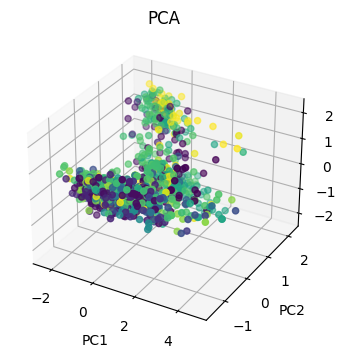

In [5]:
# load the embedding checkpoint
result = spark.read.parquet(config.intermediate_embeddings_path).persist(StorageLevel.DISK_ONLY).sample(False, 0.1, seed=42)

test_classes = [
    '2016-brussels-airport-explossion.ids',
    '2016-lahoreblast.ids',
    '2015-hurricanepatricia.ids'
    ]

brexit_elements = result.filter(result.label == '2016-brexit.ids')
train_brexit_elements, test_brexit_elements = brexit_elements.randomSplit([0.7, 0.3], seed=42)

# get the test set and the train set based on the test classes
test_set = result.filter(result.label.isin(test_classes))
test_set = test_set.union(train_brexit_elements).persist(StorageLevel.DISK_ONLY)
print("Test Set Count: ", test_set.count())
print("Test Set Classes: ", test_set.groupBy("label").count().collect())

train_set = result.filter(~result.label.isin(test_classes[:-1]))
train_set = train_set.union(test_brexit_elements).persist(StorageLevel.DISK_ONLY)
print("Train Set Count: ", result.count())
print("Train Set Classes: ", result.groupBy("label").count().collect())

l2c = init_labels()

# plot the clusters
sentence_embeddings = np.asarray(result.select("sentence_embeddings").collect()).reshape(-1, 768)
labels = [l2c[l.label] for l in result.select("label").collect()]

plot_cluster(sentence_embeddings, labels)

del sentence_embeddings, labels

In [6]:
if config.NUM_FEATURES_CLASSIFICATION == 3:
    train_set = train_set.filter(F.size(F.col("hashtags_embeddings")) > 0)
    test_set = test_set.filter(F.size(F.col("hashtags_embeddings")) > 0)
print("Number of rows in the embeddings dataframe: ", train_set.count())
print("Number of rows in the test embeddings dataframe: ", test_set.count())

Number of rows in the embeddings dataframe:  716
Number of rows in the test embeddings dataframe:  47


## Sentence Proximity

In [7]:
# retrieve the buckets
buckets = train_set.select("time_bucket").distinct().collect()
buckets = sorted([b.time_bucket for b in buckets])
print("Number of buckets: ", len(buckets))

checkpoint_df_list = []
sentence_proximity_model = None


data = train_set.select("id", "sentence_embeddings", "time_bucket")
if sentence_proximity_model is None:
    sentence_proximity_pipeline_model = sentence_proximity_pipeline.fit(data)
sentence_proximity_pipeline_result = sentence_proximity_pipeline_model.transform(data)


# concatenate the dataframes
# sentence_proximity_pipeline_result = checkpoint_df_list[0]
# for df in checkpoint_df_list[1:]:
#     sentence_proximity_pipeline_result = sentence_proximity_pipeline_result.union(df)

Number of buckets:  8
## CROSS JOIN ##
## CALCULATING DISTANCE ##
## AGGREGATING NEIGHBORS ##
## REORDERING NEIGHBORS ##


In [8]:
# rejoin the data with the original dataframe in order to
# add word and hashtag embeddings to the dataframe
sentence_proximity_pipeline_result = sentence_proximity_pipeline_result.join(result.select("id", "word_embeddings", "hashtags_embeddings"), on="id", how="left")
sentence_proximity_pipeline_result = sentence_proximity_pipeline_result.select("id", "word_embeddings", "hashtags_embeddings", F.explode("neighbors")).select("id", "word_embeddings", "hashtags_embeddings", "col.*")
sentence_proximity_pipeline_result = sentence_proximity_pipeline_result.join(result.select(F.col("id").alias("r_id_2"), F.col("word_embeddings").alias("word_embeddings_2"),  F.col("hashtags_embeddings").alias("hashtags_embeddings_2")), on=(F.col("id_2") == F.col("r_id_2")), how="left").drop("r_id_2").cache()
sentence_proximity_pipeline_result

DataFrame[id: string, word_embeddings: array<array<float>>, hashtags_embeddings: array<array<float>>, cosine_distance: float, id_2: string, word_embeddings_2: array<array<float>>, hashtags_embeddings_2: array<array<float>>]

### save the result

In [9]:
sentence_proximity_pipeline_result.write.mode("overwrite").parquet(config.intermediate_sentence_proximity_path)

### load the result

In [10]:
# load the result
sentence_proximity_pipeline_result = spark.read.parquet(config.intermediate_sentence_proximity_path)

In [11]:
sentence_proximity_pipeline_result.count()

8568

## calculate the word and hashtag proximity

In [12]:
word_and_hashtag_proximity_pipeline_model = word_and_hashtag_proximity_pipeline.fit(sentence_proximity_pipeline_result)

In [13]:

word_and_hashtag_proximity_pipeline_result = word_and_hashtag_proximity_pipeline_model.transform(sentence_proximity_pipeline_result)

## CALCULATING DISTANCES ##
## CALCULATING DISTANCES ##
## CREATING EDGES ##


### save the result

In [14]:
word_and_hashtag_proximity_pipeline_result.write.mode("overwrite").parquet(config.intermediate_word_and_hashtags_proximity_path)

### load the result

In [15]:
word_and_hashtag_proximity_pipeline_result = spark.read.parquet(config.intermediate_word_and_hashtags_proximity_path)

In [16]:
word_and_hashtag_proximity_pipeline_result.take(1)
word_and_hashtag_proximity_pipeline_result.count()

8568

## Graph Pipeline

In [17]:
edges = word_and_hashtag_proximity_pipeline_result
vertices = train_set.select("id", "label", "text")
### delete weak edges
edge_classifier_pipeline_model = edge_classifier_pipeline.fit({"edges": edges, "vertices": vertices})
edge_classifier_pipeline_result = edge_classifier_pipeline_model.transform({"edges": edges, "vertices": vertices})

## JOIN ##


23/06/14 00:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1171.1 KiB
23/06/14 00:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1641.9 KiB
23/06/14 00:30:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/06/14 00:30:41 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
23/06/14 00:30:42 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
23/06/14 00:30:44 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
23/06/14 00:30:46 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
23/06/14 00:30:48 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
23/06/14 00:30:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/06/14 00:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1114.2 KiB
23/06/14 00:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1572.1 KiB
23/06/14 00:30:59 WARN DAGScheduler: Broad

## JOIN ##
## WEIGHT CLASSIFIER ##


In [18]:
edge_classifier_pipeline_result = edge_classifier_pipeline_result.filter(F.col("label") == 1)

#### save the result

In [19]:
edge_classifier_pipeline_result.write.mode("overwrite").parquet(config.intermediate_edge_classifier_path)

23/06/14 00:31:03 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


In [20]:
edge_classifier_pipeline_result.unpersist()
word_and_hashtag_proximity_pipeline_result.unpersist()

DataFrame[src: string, dst: string, relationship: array<float>]

#### load the result

In [21]:
edge_classifier_pipeline_result = spark.read.parquet(config.intermediate_edge_classifier_path)

## Graph pipeline evaluation on the test set (simulated online phase)

In [22]:
# first clean memory from old dataframes
sentence_proximity_pipeline_result.unpersist()
word_and_hashtag_proximity_pipeline_result.unpersist()
edge_classifier_pipeline_result.unpersist()

DataFrame[src: string, dst: string, relationship: array<float>, label: int, prediction: double]

In [23]:
# cache the test set
test_set = test_set.cache()

In [24]:
# I have to get the test set and passit as a single bucket to the sentence proximity model.
# I also have to pass the train set as a single bucket to the sentence proximity model.
# By doing so, I can check the performance of the model on the test set.
# I have to do the same for the word and hashtag proximity model.
# I have to do the same for the edge classifier model.

# if config.NUM_FEATURES_CLASSIFICATION == 3:
#     test_set = test_set.filter(F.size(F.col("hashtags_embeddings")) > 0)
print("Number of rows in the embeddings dataframe: ", test_set.count())
test_set
online_sentence_proximity_pipeline = graph_pipeline.create_online_sentence_proximity_pipeline()
online_sentence_proximity_model = online_sentence_proximity_pipeline.fit(test_set)

Number of rows in the embeddings dataframe:  47


In [25]:
test_set_sentence = test_set.select("id", "label", "sentence_embeddings", "time_bucket").cache()
train_set_sentence = train_set.select("id", "label",  "sentence_embeddings", "time_bucket").cache()

In [26]:
# set the bucket for the test set to 1
test_set_sentence = test_set_sentence.withColumn("time_bucket", F.lit(1))
# set the bucket for the train set to 0
train_set_sentence = train_set_sentence.withColumn("time_bucket", F.lit(0))

# concatenate the test set and the train set
full_set_sentence = train_set_sentence.union(test_set_sentence)

In [27]:
# pass the data to the online model
online_sentence_proximity_result = online_sentence_proximity_model.transform(full_set_sentence)

## CROSS JOIN ##
## CALCULATING DISTANCE ##
## AGGREGATING NEIGHBORS ##
## REORDERING NEIGHBORS ##


In [28]:
# rejoin the data with the original dataframe in order to
# add word and hashtag embeddings to the dataframe
online_sentence_proximity_result = online_sentence_proximity_result.join(result.select("id", "word_embeddings", "hashtags_embeddings"), on="id", how="left")
online_sentence_proximity_result = online_sentence_proximity_result.select("id", "word_embeddings", "hashtags_embeddings", F.explode("neighbors")).select("id", "word_embeddings", "hashtags_embeddings", "col.*")
online_sentence_proximity_result = online_sentence_proximity_result.join(result.select(F.col("id").alias("r_id_2"), F.col("word_embeddings").alias("word_embeddings_2"),  F.col("hashtags_embeddings").alias("hashtags_embeddings_2")), on=(F.col("id_2") == F.col("r_id_2")), how="left").drop("r_id_2")


In [29]:
# test on the produced dataframe
a = online_sentence_proximity_result.take(1)
print(a[0].id)
print(a[0].word_embeddings)
print(a[0].hashtags_embeddings)
print(a[0].id_2)
print(a[0].word_embeddings_2)
print(a[0].hashtags_embeddings_2)

166491258850787328
[[-0.028262343257665634, -0.31079375743865967, -0.027235597372055054, -0.04190529137849808, 0.3555589020252228, 0.20982271432876587, -0.009104426018893719, -0.18915626406669617, -0.2049664407968521, -0.049569785594940186, 0.03943205252289772, -0.14565028250217438, 0.8858106732368469, -0.30304422974586487, 0.1268792748451233, -0.011016368865966797, -0.08716803789138794, -0.13434749841690063, 0.17050102353096008, -0.06693140417337418, 0.9390892386436462, 0.01795850321650505, -0.049247536808252335, -0.15048733353614807, -0.02727627381682396, 0.2408316433429718, -0.1371835619211197, 0.35910895466804504, -0.22590002417564392, -0.09305480122566223, -0.012526120990514755, 0.18787524104118347, -0.0008872871985659003, -0.27155643701553345, 0.1396300196647644, -0.03131254017353058, 0.1877242773771286, -0.02693026140332222, 0.2355111539363861, 0.35722967982292175, 0.2120988368988037, 0.1875559687614441, 0.09430046379566193, 0.13246676325798035, 0.04489799588918686, 0.0988756716

In [30]:
online_sentence_proximity_result.write.mode("overwrite").parquet("online_sentence_checkpoint")

In [31]:
online_sentence_proximity_result = spark.read.parquet("online_sentence_checkpoint").cache()

In [32]:
print(online_sentence_proximity_result.count())
#check if we have none
print(online_sentence_proximity_result.filter(F.col("word_embeddings").isNull()).count())

3700
0


In [33]:
word_and_hashtag_proximity_pipeline_model = word_and_hashtag_proximity_pipeline.fit(online_sentence_proximity_result)

In [34]:
# pass the data to the word and hashtag proximity model
online_word_and_hashtag_proximity_result = word_and_hashtag_proximity_pipeline_model.transform(online_sentence_proximity_result)

## CALCULATING DISTANCES ##
## CALCULATING DISTANCES ##
## CREATING EDGES ##


In [35]:
online_word_and_hashtag_proximity_result.write.mode("overwrite").parquet("online_word_and_hashtags_checkpoint")

In [36]:
online_word_and_hashtag_proximity_result = spark.read.parquet("online_word_and_hashtags_checkpoint")

In [37]:
print("tot:", online_word_and_hashtag_proximity_result.count())


id_label_src = result.select("id", "label").withColumnRenamed("id", "id_src").withColumnRenamed("label", "label_src")

xx = online_word_and_hashtag_proximity_result.join(id_label_src, on=( F.col("src") == F.col("id_src")), how="left").select("src", "dst", "label_src")

id_label_dst = id_label_src.withColumnRenamed("id_src", "id_dst").withColumnRenamed("label_src", "label_dst")
xx = xx.join(id_label_dst, on=(F.col("dst") == F.col("id_dst")), how="left").select("label_src", "label_dst")

print("correct:", xx.filter(F.col("label_src") == F.col("label_dst")).count())
print("wrong:", xx.filter(F.col("label_src") != F.col("label_dst")).count())


tot: 3700


correct: 136
wrong: 3564


In [38]:
# set the bucket for the test set to 1
print(test_set_sentence.count())
# set the bucket for the train set to 0
print(train_set_sentence.count())

47
716


In [ ]:
# now pass the data to the already trained edge classifier model
test_edges = edge_classifier_pipeline_model.transform({"edges": online_word_and_hashtag_proximity_result, "vertices": result.select("id", "label", "text")}).filter(F.col("prediction") == 1)

In [1]:
test_edges.rdd.count()

NameError: name 'test_edges' is not defined

In [41]:
test_edges.write.mode("overwrite").parquet("test_edge_classifier_checkpoint")

23/06/14 00:34:15 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/06/14 00:34:16 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/06/14 00:34:16 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


In [42]:
test_edges = spark.read.parquet("test_edge_classifier_checkpoint")

# Calculate Metrics

In [43]:
# first join the src and the dst with their labes

id_label_src = result.select("id", "label").withColumnRenamed("id", "id_src").withColumnRenamed("label", "label_src")

xx = test_edges.join(id_label_src, on=( F.col("src") == F.col("id_src")), how="left").select("src", "dst", "label_src")

id_label_dst = id_label_src.withColumnRenamed("id_src", "id_dst").withColumnRenamed("label_src", "label_dst")
xx = xx.join(id_label_dst, on=(F.col("dst") == F.col("id_dst")), how="left").select("label_src", "label_dst")

In [44]:
print(xx.count())
print(xx.filter(F.col("label_src") == F.col("label_dst")).count())

136
91


## Graph

#### Create the Graph

In [45]:
if not edge_classifier_pipeline_result.is_cached:
    edge_classifier_pipeline_result = spark.read.parquet("edge_classifier_checkpoint")
if not test_edges.is_cached:
    test_edges = spark.read.parquet("test_edge_classifier_checkpoint")
# take all the edges that have been classified as positive from the train and the test set
edges = test_edges.union(edge_classifier_pipeline_result)
# take all the vretices
vertices = result.select("id", "label", "text")

proximity_graph = GraphFrame(vertices, edges)
ig: Graph = Graph.TupleList(proximity_graph.edges.collect(), directed=False)
vertex_colors = [label_to_color[result.select("label").filter(F.col("id") == int(vertex['name'])).collect()[0][0]] for vertex in ig.vs]
connected_components: VertexClustering= ig.connected_components()

/home/andrea/miniconda3/envs/tweepic/lib/python3.10/site-packages/pyspark/sql/dataframe.py:169: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


#### Plot the Graph

#### Graph

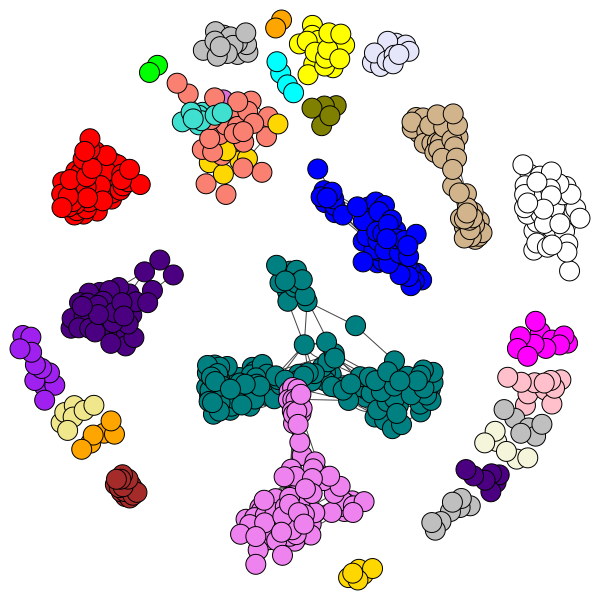

In [46]:
pl = plot(ig, vertex_color=vertex_colors)
pl.save("images/colored_graph.png")
pl

##### Connected Components

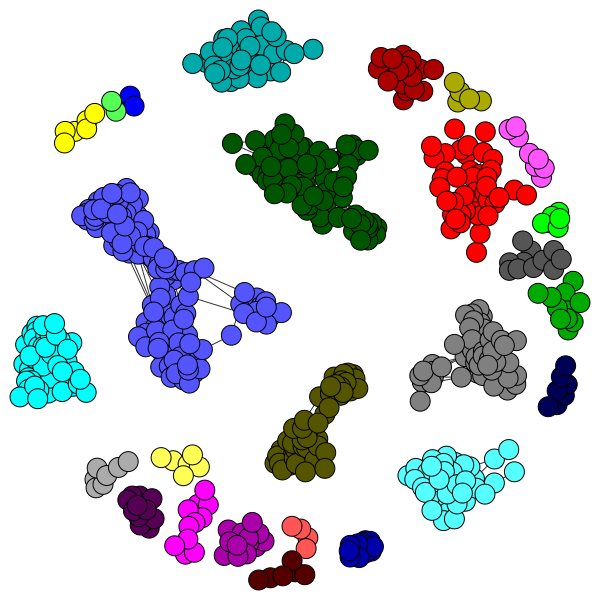

In [47]:
cc = plot(connected_components)
cc.save("images/connected_components.png")
cc

In [48]:

# take all the edges that have been classified as positive from the train and the test set
edges = test_edges
# take all the vretices
vertices = result.select("id", "label", "text")

proximity_graph = GraphFrame(vertices, edges)
ig: Graph = Graph.TupleList(proximity_graph.edges.collect(), directed=False)
vertex_colors = [label_to_color[result.select("label").filter(F.col("id") == int(vertex['name'])).collect()[0][0]] for vertex in ig.vs]
connected_components: VertexClustering= ig.connected_components()

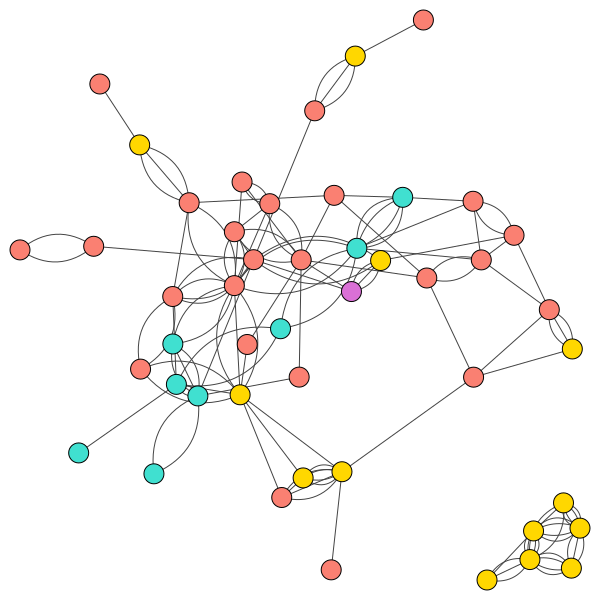

In [49]:
pl = plot(ig, vertex_color=vertex_colors)
pl.save("images/colored_graph_only_new.png")
pl

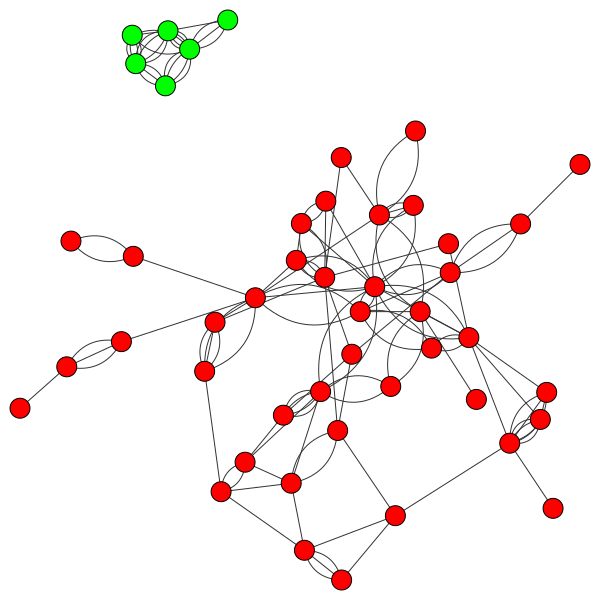

In [50]:
cc = plot(connected_components)
cc.save("images/connected_components_only_new.png")
cc

In [51]:
# take all the edges that have been classified as positive from the train and the test set
edges = edge_classifier_pipeline_result
# take all the vretices
vertices = result.select("id", "label", "text")

proximity_graph = GraphFrame(vertices, edges)
ig: Graph = Graph.TupleList(proximity_graph.edges.collect(), directed=False)
vertex_colors = [label_to_color[result.select("label").filter(F.col("id") == int(vertex['name'])).collect()[0][0]] for vertex in ig.vs]
connected_components: VertexClustering= ig.connected_components()

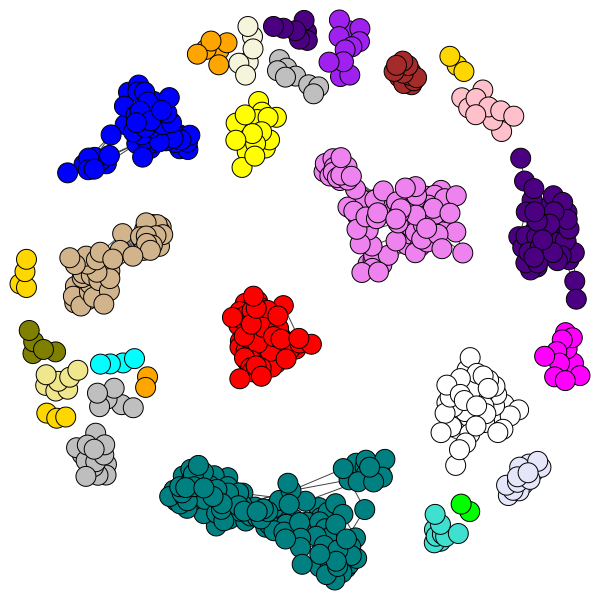

In [52]:
pl = plot(ig, vertex_color=vertex_colors)
pl.save("images/colored_graph_only_new.png")
pl

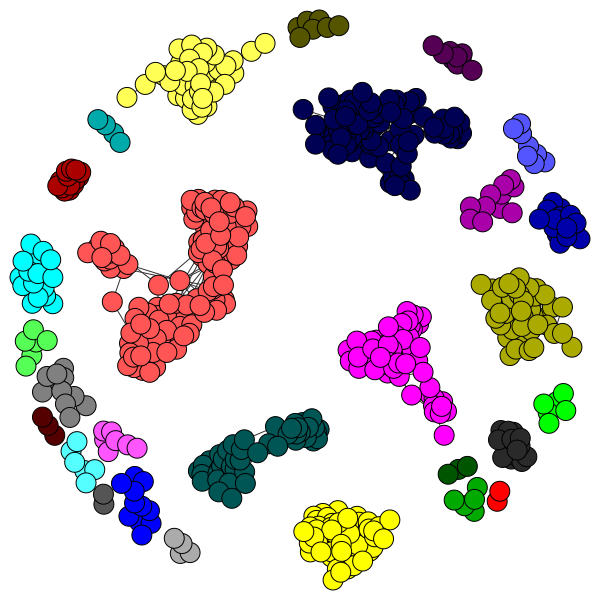

In [53]:
cc = plot(connected_components)
cc.save("images/connected_components_only_new.png")
cc

## save the graph s.t. it can be exported to graphistry

In [54]:
vertices = vertices.withColumn("text", F.regexp_replace(F.col("text"), "\t", " "))
vertices = vertices.withColumn("text", F.regexp_replace(F.col("text"), "\n", " "))
vertices = vertices.withColumn("text", F.regexp_replace(F.col("text"), ",", " "))

In [ ]:
final_edges = edge_classifier_pipeline_result
spark.createDataFrame([["src", "dst"]], ["src", "dst"]).union(final_edges.drop("relationship", "label")).write.mode("overwrite").format("csv").save("final_graph.csv")

spark.createDataFrame([["id", "label", "text"]], ["id", "label", "text"]).union(vertices).write.mode("overwrite").format("csv").save("final_nodes.csv")